In [1]:
import kenlm
import multiprocessing, os, sys
import numpy as np
import subprocess
import matplotlib.pyplot as plt
sys.path.append('../')
%load_ext autoreload
%autoreload 2

## use kenlm to generate scores

In [7]:
class KenlmWrapper(object):
    def __init__(self, model):
        self.model = model
        self.clear()
    
    def clear(self):
        self.score_accum = 0
        self.last_state = kenlm.State()
        self.new_state = kenlm.State()
        return self
    
    def init(self):
        self.clear()
        self.model.BeginSentenceWrite(self.last_state)
        return self
    
    def next_score(self, word):
        s = self.model.BaseScore(self.last_state, word, self.new_state)
        self.score_accum += s
        tmp = self.last_state
        self.last_state = self.new_state
        self.new_state = tmp
        return s

In [8]:
def _lm_examine(args):
    filepath, out_filepath, model, ind, start, end = args
    kenlm_wrapper = KenlmWrapper(model)
    out_filepath = '{}.{}'.format(out_filepath, ind)
    with open(filepath, 'r') as fin, open(out_filepath, 'w') as fout:
        for i, l in enumerate(fin):
            if i < start:
                continue
            if i >= end:
                break
            words = l.strip().split()
            if len(words) == 0:
                continue
            kenlm_wrapper.init().next_score(words[0]) # initialize the sentence
            for word in words[1:]:
                score = kenlm_wrapper.next_score(word) # calculate score
                fout.write('{:.5f}\n'.format(score))
def lm_examine(filepath, out_filepath, model_path, num_thread=4):
    model = kenlm.LanguageModel(model_path)
    num_lines = sum(1 for l in open(filepath, 'r'))
    print('num lines {}'.format(num_lines))
    batch_size = int(np.ceil(num_lines / num_thread))
    with multiprocessing.Pool(num_thread) as p:
        print(p.map(_lm_examine, [(filepath, out_filepath, model, i, i*batch_size, i*batch_size+batch_size) 
                                  for i in range(num_thread)]))

In [47]:
lm_examine(os.path.join('/usr0/home/zhengbaj/data/',
                        'lm/1-billion-word-language-modeling-benchmark-r13output',
                        'training-monolingual.tokenized.shuffled',
                        'news.en-00001-of-00100'),
           '1b_lm_examine', '1b.binary', num_thread=4)
subprocess.run("cat 1b_lm_examine.{0..3} > 1b_lm_examine", shell=True, executable='/bin/bash', check=True)

num lines 306068
[None, None, None, None]


CompletedProcess(args='cat 1b_lm_examine.{0..3} > 1b_lm_examine', returncode=0)

## kenlm test

In [36]:
def kenlm_test():
    model = kenlm.LanguageModel('1b.binary')
    kenlm_wrapper = KenlmWrapper(model)
    kenlm_wrapper.init()
    print(kenlm_wrapper.next_score('i'))
    print(kenlm_wrapper.next_score('have'))
    print(kenlm_wrapper.next_score('a'))
    print(kenlm_wrapper.next_score('lot'))
    print(kenlm_wrapper.next_score('of'))
    print(kenlm_wrapper.next_score('voices'))
kenlm_test()

-5.992492198944092
-1.5513503551483154
-0.9852211475372314
-2.0829129219055176
-0.31264644861221313
-4.039732933044434


In [ ]:
9.384115219116211

## visualize the histogram of scores

In [62]:
def hist_score(filepath, num_bins=100, cut_percentile=10):
    scores = np.array(list(map(lambda x: float(x), open(filepath, 'r').read().split())))
    n, bins, patches = plt.hist(scores, num_bins, facecolor='blue', cumulative=True, normed=True)
    plt.show()
    cut_value = cut_percentile / 100
    for i in range(len(n)):
        if n[i] >= cut_value:
            return bins[i+1]

/usr1/home/zhengbaj/exp/env_python3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


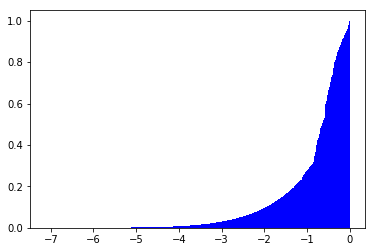

-2.5663104

In [63]:
hist_score('1b_lm_examine', num_bins=500, cut_percentile=5)

## split document using kenlm and the threshold

In [24]:
from utils import load_prep_file, load_prep_file_aslist, save_prep_file, Vocab

In [15]:
data_dir = '../data/bing'
doc_filepath = os.path.join(data_dir, 'docs.prep')
vocab_filepath = os.path.join(data_dir, 'vocab')
file_format = 'ir'

In [32]:
def split_document(model_path, doc_filepath, vocab_filepath, file_format, out_filepath, thres):
    model = kenlm.LanguageModel(model_path)
    kenlm_wrapper = KenlmWrapper(model)
    docs = load_prep_file_aslist(doc_filepath, file_format=file_format, use_split=True)
    #docs = load_prep_file(doc_filepath, file_format=file_format)
    docs_seg = []
    docs_seg_debug = []
    vocab = Vocab(filepath=vocab_filepath, file_format=file_format)
    print('start spliting')
    for i, (k, inds) in enumerate(docs):
        if i % 50000 == 0:
            print(i/50000)
        words = vocab.decode(inds)
        seg = [1]
        seg_debug = ['|', words[0]]
        kenlm_wrapper.init().next_score(words[0]) # first word
        for word in words[1:]:
            score = kenlm_wrapper.next_score(word)
            if score >= thres:
                seg.append(0)
                seg_debug.append(word)
            else:
                seg.append(1)
                kenlm_wrapper.init().next_score(word)
                seg_debug.append('|')
                seg_debug.append(word)
        docs_seg.append((k, seg))
        docs_seg_debug.append((k, seg_debug))
    save_prep_file(out_filepath, docs_seg, file_format=file_format)
    save_prep_file(out_filepath + '.debug', docs_seg_debug, file_format=file_format)

In [37]:
%%capture output
split_document('1b.binary', doc_filepath, vocab_filepath, file_format=file_format, 
               out_filepath='docs.seg', thres=-2.56)